In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision
import os
import matplotlib.pyplot as plt
from PIL import Image
from gensim.models import Word2Vec,FastText
from tqdm import tqdm
import random

C:\Users\a9473\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
torch.backends.cudnn.deterministic = True
torch.set_default_tensor_type('torch.DoubleTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()


In [4]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batchSize = x.shape[0]
        return x.view(batchSize, -1)

flatten = Flatten()


In [5]:
class Make4D(torch.nn.Module):
    def forward(self, x):
        batchSize = x.shape[0]
        return x.view(batchSize,-1,1,1)

make4d = Make4D()


In [32]:
def Accuracy(predicted,true):
    '''
    return sum of correct predicted token
    '''
    _noCorrect = []
    for i in range(54):
        _cap = predicted[i]
        _true = true[i]
    
        _cap = _cap.split()
        _true = _true.split()
        _noCorrect.append(np.array([1 for i, j in zip(_true, _cap) if i == j],dtype=np.int8).sum())
    return np.array(_noCorrect).sum()



    

In [33]:
def PerfectAccuracy(predicted,true):
    '''
    return sum of correct predicted caption
    '''
    _noCorrect = np.zeros((54,1))
    for i in range(54):
        _cap = predicted[i]
        _true = true[i]  
        _cap = _cap.split()
        _true = _true.split()
        if _true == _cap:
            _noCorrect[i] =+1
    return np.array(_noCorrect).sum()   

In [6]:
class dataset(Dataset):

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """

        self.caption_file = pd.read_csv(csv_file,header=None)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.caption_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.caption_file.iloc[idx, 0])
        image = Image.open(img_name)
        image = torchvision.transforms.functional.to_grayscale(image, num_output_channels=1)    #RGB -> GrayScale
        image = np.array(image,dtype=np.float)
        image = torch.from_numpy(image)
        image = (image.max()-image)/(image.max()-image.min()) #normalize
        caption = self.caption_file.iloc[idx, 1]
        sample = image,caption


        return sample
    

In [7]:
dataset_ = dataset("dataset_v2.csv","dataset")

dataloader = DataLoader(dataset_, batch_size=54,shuffle=True)

In [8]:
image , cap = next(iter(dataloader))

print("shape of image is {0}".format(image.shape))
print("shape of caption is {0}".format(len(cap)))

shape of image is torch.Size([54, 100, 100])
shape of caption is 54


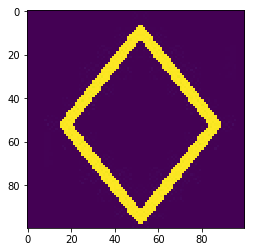

a big diamond in center


In [9]:
imshow(image[0])

print(cap[0])

In [11]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self):
        '''
        MLP Encoder-Decoder for encoding images 
        it receives 100*100 images, down-sample them to 10 dim vectors
        then trys to reconstruct to what they really were.
        '''
        super().__init__()
        
        self.encode = torch.nn.Sequential(
                flatten,
                torch.nn.Linear(100*100,1000),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(1000,500),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(500,100),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(100,10),
                torch.nn.ReLU(inplace=True)
                )
        self.decode = torch.nn.Sequential(
                torch.nn.Linear(10,100),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(100,500),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(500,1000),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(1000,100*100),
                torch.nn.ReLU()
                )
        
    def forward(self,input):
        batchSize = input.size()[0]
        input = input.to(device)
        input = self.encode(input)
        return self.decode(input).view(batchSize,100,100)


In [12]:
encoderdecoder=EncoderDecoder()
criterion =  torch.nn.MSELoss()
ed_optimizer = torch.optim.Adam(encoderdecoder.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = criterion.to(device)
encoderdecoder = encoderdecoder.to(device)



loss --> 0.060644576596512005 in epoch 1


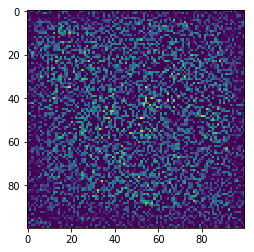

loss --> 0.05983516831535122 in epoch 2
loss --> 0.05895089238835508 in epoch 3
loss --> 0.058570338411525126 in epoch 4
loss --> 0.058512376961083704 in epoch 5
loss --> 0.058021197118720384 in epoch 6
loss --> 0.05767099384599734 in epoch 7
loss --> 0.05737585229750743 in epoch 8
loss --> 0.05725750666564297 in epoch 9
loss --> 0.05706022954343489 in epoch 10
loss --> 0.05680357013871959 in epoch 11


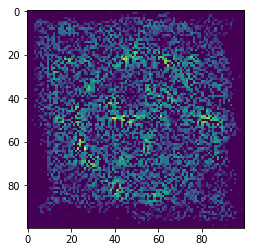

loss --> 0.056694953097032354 in epoch 12
loss --> 0.056410890615357 in epoch 13
loss --> 0.0563215668493929 in epoch 14
loss --> 0.05615417005401487 in epoch 15
loss --> 0.056044833048351554 in epoch 16
loss --> 0.05584788798359381 in epoch 17
loss --> 0.0556809589072326 in epoch 18
loss --> 0.05546994414204188 in epoch 19
loss --> 0.055265991193161695 in epoch 20
loss --> 0.055000387124532396 in epoch 21


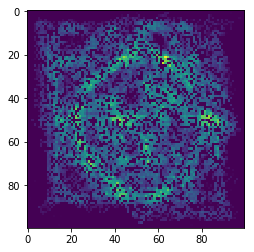

loss --> 0.05474492974835492 in epoch 22
loss --> 0.054428500096581164 in epoch 23
loss --> 0.05414472432580732 in epoch 24
loss --> 0.05372761370430863 in epoch 25
loss --> 0.0532774404426298 in epoch 26
loss --> 0.05287913694331386 in epoch 27
loss --> 0.05256070486725341 in epoch 28
loss --> 0.05209659901387423 in epoch 29
loss --> 0.05161920944126248 in epoch 30
loss --> 0.05098575038296689 in epoch 31


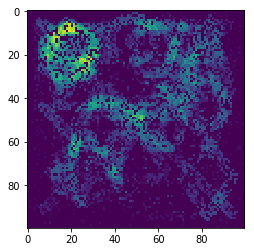

loss --> 0.050332045815839214 in epoch 32
loss --> 0.04969035694023746 in epoch 33
loss --> 0.0491601251811582 in epoch 34
loss --> 0.048406355549438396 in epoch 35
loss --> 0.04781335341014779 in epoch 36
loss --> 0.047208510262545404 in epoch 37
loss --> 0.04642955764764382 in epoch 38
loss --> 0.0455435386349826 in epoch 39
loss --> 0.04452429405861056 in epoch 40
loss --> 0.043661202686904654 in epoch 41


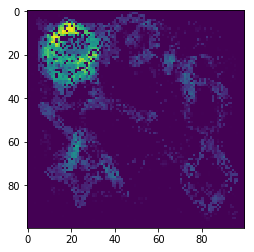

loss --> 0.04284253872706183 in epoch 42
loss --> 0.04258396699940289 in epoch 43
loss --> 0.04161317445538698 in epoch 44
loss --> 0.04086053683054943 in epoch 45
loss --> 0.039007263410896297 in epoch 46
loss --> 0.038939244801011255 in epoch 47
loss --> 0.036971619836610334 in epoch 48
loss --> 0.03673062696976701 in epoch 49
loss --> 0.035010312396417984 in epoch 50
loss --> 0.03443916555020513 in epoch 51


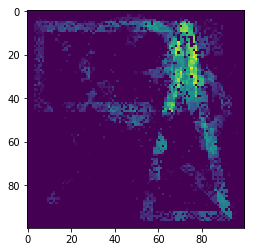

loss --> 0.03311006521008535 in epoch 52
loss --> 0.03226149892873996 in epoch 53
loss --> 0.031151431968339346 in epoch 54
loss --> 0.030187486503505504 in epoch 55
loss --> 0.028951699109059047 in epoch 56
loss --> 0.028247787728637872 in epoch 57
loss --> 0.027472247973378494 in epoch 58
loss --> 0.028415296268316587 in epoch 59
loss --> 0.02790280046832674 in epoch 60
loss --> 0.02528261430375558 in epoch 61


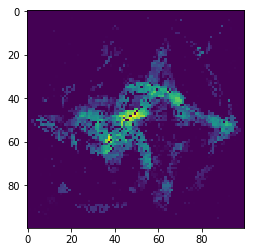

loss --> 0.02515693951993394 in epoch 62
loss --> 0.023446128088899648 in epoch 63
loss --> 0.02296062956759535 in epoch 64
loss --> 0.021846560313029607 in epoch 65
loss --> 0.02097401337371431 in epoch 66
loss --> 0.02013807364936891 in epoch 67
loss --> 0.01924715911200367 in epoch 68
loss --> 0.018570821674783067 in epoch 69
loss --> 0.017645100922277196 in epoch 70
loss --> 0.01729010061537705 in epoch 71


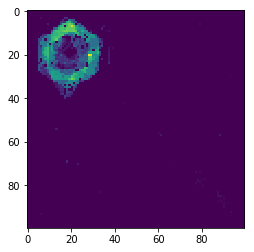

loss --> 0.016309967163291125 in epoch 72
loss --> 0.015749399034093652 in epoch 73
loss --> 0.01524355842173838 in epoch 74
loss --> 0.01467050397436068 in epoch 75
loss --> 0.01474630772941669 in epoch 76
loss --> 0.014418349263200653 in epoch 77
loss --> 0.013620775475391986 in epoch 78
loss --> 0.012594755045880457 in epoch 79
loss --> 0.012775621474089451 in epoch 80
loss --> 0.011928023775230416 in epoch 81


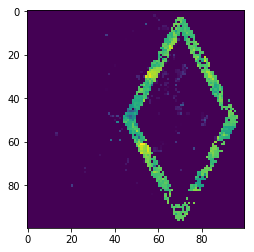

loss --> 0.011285518543177222 in epoch 82
loss --> 0.011095783448997816 in epoch 83
loss --> 0.01030108853555555 in epoch 84
loss --> 0.010388710695382566 in epoch 85
loss --> 0.009550556022236355 in epoch 86
loss --> 0.009481728257700208 in epoch 87
loss --> 0.008951728495972588 in epoch 88
loss --> 0.008780392140961605 in epoch 89
loss --> 0.008423283116626714 in epoch 90
loss --> 0.008176391198316897 in epoch 91


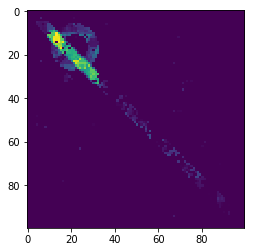

loss --> 0.00796204614696916 in epoch 92
loss --> 0.00767635616738914 in epoch 93
loss --> 0.007525288930380832 in epoch 94
loss --> 0.007349687448560385 in epoch 95
loss --> 0.007185418339613059 in epoch 96
loss --> 0.007198920956741487 in epoch 97
loss --> 0.007366389619217792 in epoch 98
loss --> 0.007938062630481307 in epoch 99
loss --> 0.00855630490928274 in epoch 100
loss --> 0.007481053586243383 in epoch 101


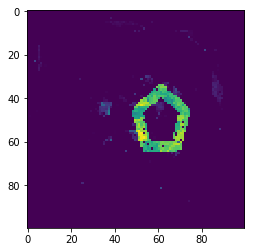

loss --> 0.0072205677212624445 in epoch 102
loss --> 0.007244985502879809 in epoch 103
loss --> 0.006902373482129426 in epoch 104
loss --> 0.006700338969026691 in epoch 105
loss --> 0.006758812126684084 in epoch 106
loss --> 0.006435422959728545 in epoch 107
loss --> 0.00656844215677016 in epoch 108
loss --> 0.006218409507478573 in epoch 109
loss --> 0.006309752022538739 in epoch 110
loss --> 0.006078811801880259 in epoch 111


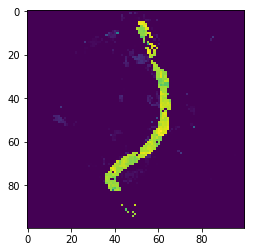

loss --> 0.00607458493856704 in epoch 112
loss --> 0.00599956007491512 in epoch 113
loss --> 0.005885352049292564 in epoch 114
loss --> 0.005897425032216965 in epoch 115
loss --> 0.005779472396714212 in epoch 116
loss --> 0.005769345558263557 in epoch 117
loss --> 0.0057001968133045715 in epoch 118
loss --> 0.00565295958091425 in epoch 119
loss --> 0.00563684727916279 in epoch 120
loss --> 0.005581798991021803 in epoch 121


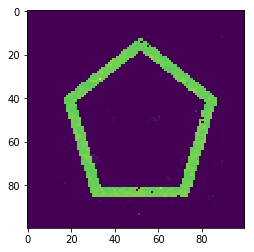

loss --> 0.005560242622232931 in epoch 122
loss --> 0.005544854415146614 in epoch 123
loss --> 0.005512858095435423 in epoch 124
loss --> 0.005484654054576518 in epoch 125
loss --> 0.005440259886583022 in epoch 126
loss --> 0.00542112715269413 in epoch 127
loss --> 0.005404998171280662 in epoch 128
loss --> 0.0053555068852349065 in epoch 129
loss --> 0.005345007342517264 in epoch 130
loss --> 0.0053059513455172005 in epoch 131


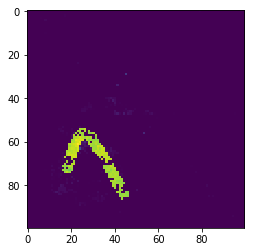

loss --> 0.005271801015585579 in epoch 132
loss --> 0.005245783578402035 in epoch 133
loss --> 0.005266469459546537 in epoch 134
loss --> 0.005427106366055004 in epoch 135
loss --> 0.006728389421130988 in epoch 136
loss --> 0.017740574544045446 in epoch 137
loss --> 0.03367796114056191 in epoch 138
loss --> 0.018920815843688515 in epoch 139
loss --> 0.018623580745944654 in epoch 140
loss --> 0.022566837683273673 in epoch 141


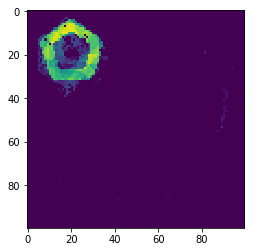

loss --> 0.015673218609517498 in epoch 142
loss --> 0.013625365157204219 in epoch 143
loss --> 0.01416203666571496 in epoch 144
loss --> 0.014096100859456777 in epoch 145
loss --> 0.011882335789571402 in epoch 146
loss --> 0.010398744077968662 in epoch 147
loss --> 0.010025065467491946 in epoch 148
loss --> 0.0092095202832775 in epoch 149
loss --> 0.008440637373132446 in epoch 150
loss --> 0.007899565928978936 in epoch 151


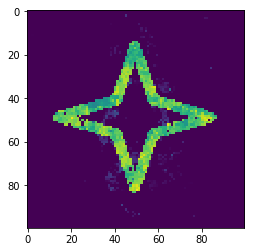

loss --> 0.007331035770595922 in epoch 152
loss --> 0.0067986268542130305 in epoch 153
loss --> 0.006416974374430356 in epoch 154
loss --> 0.006159657713291205 in epoch 155
loss --> 0.005893210233749632 in epoch 156
loss --> 0.005700587938496987 in epoch 157
loss --> 0.005531693905276478 in epoch 158
loss --> 0.005395692795596011 in epoch 159
loss --> 0.005280489443887489 in epoch 160
loss --> 0.005173072730277878 in epoch 161


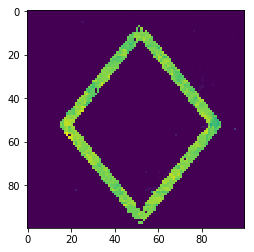

loss --> 0.005098599254458956 in epoch 162
loss --> 0.0050258568832899485 in epoch 163
loss --> 0.004967895058235913 in epoch 164
loss --> 0.004917476935977738 in epoch 165
loss --> 0.004873036259805989 in epoch 166
loss --> 0.004826951783476 in epoch 167
loss --> 0.004790071533108817 in epoch 168
loss --> 0.004761972636707784 in epoch 169
loss --> 0.004743175727868859 in epoch 170
loss --> 0.00471235112088756 in epoch 171


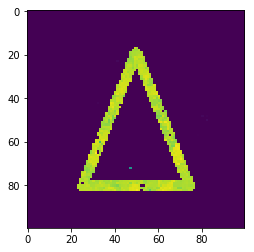

loss --> 0.0046841937015911035 in epoch 172
loss --> 0.004666785325302377 in epoch 173
loss --> 0.004646794311001703 in epoch 174
loss --> 0.004643794446042409 in epoch 175
loss --> 0.0046140083912423 in epoch 176
loss --> 0.0046064900438485025 in epoch 177
loss --> 0.0045903411557289735 in epoch 178
loss --> 0.004576733081039669 in epoch 179
loss --> 0.004564798343910272 in epoch 180
loss --> 0.004551127060650474 in epoch 181


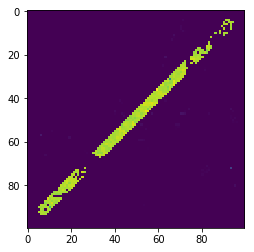

loss --> 0.004543067580373316 in epoch 182
loss --> 0.0045309331861186335 in epoch 183
loss --> 0.004519918380831922 in epoch 184
loss --> 0.00451104709334052 in epoch 185
loss --> 0.00450653186819609 in epoch 186
loss --> 0.004501062881169106 in epoch 187
loss --> 0.00449349309604598 in epoch 188
loss --> 0.004489390856309649 in epoch 189
loss --> 0.004478532730100583 in epoch 190
loss --> 0.004475748505686945 in epoch 191


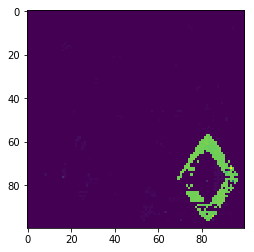

loss --> 0.004473305825416093 in epoch 192
loss --> 0.00446369325783401 in epoch 193
loss --> 0.004457665027428021 in epoch 194
loss --> 0.004451724221749961 in epoch 195
loss --> 0.004445475319883639 in epoch 196


In [13]:
for epoch in range(196): #after some runs 196 epoch is chosen
    for image , _ in dataloader:        
        computed = encoderdecoder(image) 
        loss = criterion(computed,image.to(device))    
        ed_optimizer.zero_grad()    
        loss.backward()    
        ed_optimizer.step()

    
    
        print("loss --> {0} in epoch {1}".format(loss.mean().item(),1+epoch))
        if epoch % 10 == 0:
            
            tmp = image[10]  
            tmp = tmp.numpy() 
            tmp=tmp.reshape(1,100,100)
            tmp = torch.from_numpy(tmp)

            with torch.no_grad():
                img = encoderdecoder(tmp)
                img = img.cpu().reshape(100,100)
                imshow(img)    
    


In [15]:
ED_save_name = 'encoderdecoder.pt'
EDpath = r".\{ED_save_name}"
torch.save(encoderdecoder.state_dict(),EDpath)


In [16]:
encoderdecoder.load_state_dict(torch.load(EDpath)) 
encoder = encoderdecoder.encode #delete decode part
del encoderdecoder

for param in encoder.parameters():
    param.requires_grad = False

In [17]:
def padCap(captions):
    '''
    pad captions to lentgh of 7 with <e> token (maximum lentgh)
    '''
    _captions=[]
    for _ in captions :
        lentgh = len(_.split())
    
        if lentgh < 7:
            for i in range(7-lentgh):
                _ = _ +" <e>"
            
        _captions.append(_)
        
    return _captions

In [18]:
def createWord2Count(captions):
    '''
    for tracking vocabulary and corresponding counts
    '''
    word2count = {}
    for line in captions:
        for word in line.split():
            if word not in word2count:
                word2count[word] = 1
            else:
                word2count[word] += 1
    return word2count

In [21]:
captions = padCap(cap)
word2count = createWord2Count(captions)

print("padded caption")
print(captions[:10])
print()
print()
print("word2count dictionary")
print(list(word2count.items())[:10])

padded caption
['a big diamond in center <e> <e>', 'a small star in lower left <e>', 'a short straight line in center <e>', 'a small circle in upper left <e>', 'a small rectangle in upper right <e>', 'a small triangle in upper left <e>', 'a big star in center <e> <e>', 'a small rectangle in center <e> <e>', 'a big rectangle in upper left <e>', 'a small hexagon in upper left <e>']


word2count dictionary
[('a', 54), ('big', 21), ('diamond', 6), ('in', 36), ('center', 13), ('<e>', 96), ('small', 21), ('star', 6), ('lower', 5), ('left', 17)]


In [22]:
sentences_ted=[]           
for line in captions:
    sentences_ted.append(line.split())


sentences_ted[:3]

[['a', 'big', 'diamond', 'in', 'center', '<e>', '<e>'],
 ['a', 'small', 'star', 'in', 'lower', 'left', '<e>'],
 ['a', 'short', 'straight', 'line', 'in', 'center', '<e>']]

In [28]:
model=Word2Vec(size=5, workers=-1,min_count=0,window=3)
model.build_vocab(sentences_ted)
model.train(sentences_ted,total_words=len(word2count.keys()) ,epochs=200)

#training word2vec model

(0, 0)

In [26]:
def prepareBatch(images,captions,model_wv,maxLentgh,embedDim):
    '''
    preparing batches for training 
    encoding images with encoder and turn caption to embedding
    
    args
    model_wv (gensim word2vec model)
    maxLentgh(int) maximum lentgh of captions
    embedDim (int) dimension of embeding
    '''
    
    batchSize = images.size()[0]
    encodedImage=encoder(images.to(device))
    embeddCapMatrix = np.zeros((batchSize,maxLentgh*embedDim))
    captions = padCap(captions)
  
    for i in range(batchSize):
        temp = []
        for word in captions[i].split():
            temp.append(model.wv.get_vector(word))
        embeddCapMatrix[i,:] = np.asarray(temp).reshape(1,-1)
    return encodedImage,torch.from_numpy(embeddCapMatrix).double()
    

In [29]:
BatchImage,BatchCap = prepareBatch(image,cap,model,7,5)

print(BatchCap.shape)
print(BatchImage.shape)

torch.Size([54, 35])
torch.Size([54, 10])


In [31]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
       
        self.main = torch.nn.Sequential(
            torch.nn.Linear(10,1024),
            torch.nn.BatchNorm1d(1024,momentum=0.01),
            torch.nn.LeakyReLU(inplace=True),
            make4d,
     
            torch.nn.ConvTranspose2d(1024,512,(3,3), bias=False),
            torch.nn.BatchNorm2d(512,momentum=0.01),
            torch.nn.LeakyReLU(inplace=True),

            torch.nn.ConvTranspose2d(512,256,(3,3), bias=False),
            torch.nn.BatchNorm2d(256,momentum=0.01),
            torch.nn.LeakyReLU(inplace=True),
        
            torch.nn.ConvTranspose2d(256,1,(3,1), bias=False),
            torch.nn.BatchNorm2d(1,momentum=0.01),
            torch.nn.Tanh())
    
    def forward(self,input):
        batchSize = input.shape[0]
        input = input.to(device)
        return self.main(input).view(batchSize,-1)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.main = torch.nn.Sequential(
            
            torch.nn.Conv2d(1,512,(3,3), bias=False),
            torch.nn.BatchNorm2d(512,momentum=0.01),
            torch.nn.LeakyReLU(inplace=True),

            torch.nn.Conv2d(512,256,(3,3), bias=False),
            torch.nn.BatchNorm2d(256,momentum=0.01),
            torch.nn.LeakyReLU(inplace=True),

            torch.nn.Conv2d(256,1,(3,1), bias=False),
            torch.nn.BatchNorm2d(1,momentum=0.01),
            torch.nn.LeakyReLU(inplace=True),
        
            flatten,

            torch.nn.Linear(3,1),
            torch.nn.Sigmoid())
    
    def forward(self,embed,encodedImage):
        batchSize = embed.shape[0]
        embed = embed.to(device)
        input = torch.cat((embed, encodedImage.to(device)), 1).view(batchSize,1,9,5)
        return self.main(input)

In [43]:
generator = Generator()
discriminator = Discriminator()


    
criterion = torch.nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001,betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001,betas=(0.5, 0.999))


generator.to(device)
discriminator.to(device)
criterion.to(device)




D_save_name = 'discriminator.pt'
G_save_name ='generator.pt'

Gpath =  "./generator.pt"
Dpath = "./discriminator.pt"



In [ ]:

num_epochs = 6000

Gerr = []
Derr = []
DX = []
DG1 = []
DG2 = []
noCorrect = []
noPerfectCorrect = []



for epoch in tqdm(num_epochs):
    for images, caps in dataloader:
        batchsize = images.shape[0]
        ei,embed=prepareBatch(images,caps,model,7,5)        
        ei = ei.to(device)
        embed = embed.to(device)    
        discriminator.zero_grad()
        target = torch.ones((batchsize,1),requires_grad=False).to(device).double()
        output = discriminator(embed,ei)
        errD_real = criterion(output, target)
        errD_real.backward()
        D_x = output.mean().item()    
        fake = generator(ei)
        target = torch.zeros((batchsize,1),requires_grad=False).to(device).double()

        output = discriminator(fake.detach(),ei)
        errD_fake = criterion(output, target)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        d_optimizer.step()

        generator.zero_grad()
        target = torch.ones((batchsize,1),requires_grad=False).to(device).double()
        output = discriminator(fake,ei)
        errG = criterion(output, target)
        errG.backward()
        D_G_z2 = output.mean().item()
        g_optimizer.step()
        Gerr.append(errG.item())
        Derr.append(errD.item())
        DX.append(D_x)
        DG1.append(D_G_z1)
        DG2.append(D_G_z2) 
        
        if epoch%20 == 0:
            generator.eval()
            with torch.no_grad():
                predictedEmbed=generator(ei)
            predictedEmbed = predictedEmbed.cpu().numpy().reshape(54,7,5)

            predictedCap = []

            for _ in predictedEmbed:
                temp = ""
                for j in _:
                    temp= temp+" "+model.wv.most_similar(positive=[j],topn=1)[0][0]
                predictedCap.append(temp)
            generator.train()        
            noCorrect.append(Accuracy(padCap(caps),predictedCap))
            noPerfectCorrect.append(PerfectAccuracy(padCap(caps),predictedCap))

        
      
    torch.save(discriminator.state_dict(),Dpath)
    torch.save(generator.state_dict(),Gpath)

In [45]:
discriminator.load_state_dict(torch.load(Dpath))
generator.load_state_dict(torch.load(Gpath))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

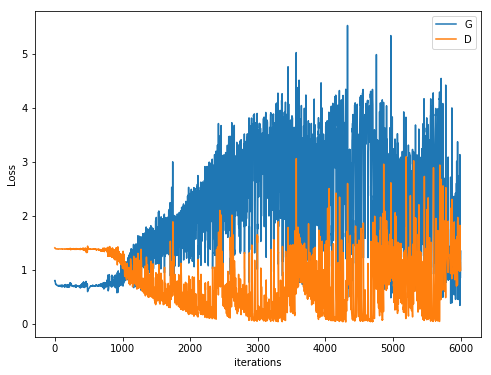

Discriminator Error vs Generator Error


In [36]:
plt.figure(figsize=(8,6))
plt.plot(Gerr,label="G")
plt.plot(Derr,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("Discriminator Error vs Generator Error")

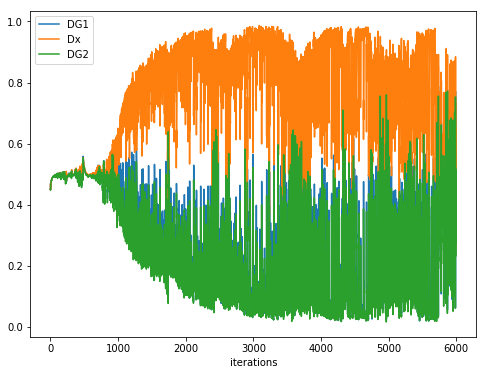

D(G(ei))in first phase vs D(G(ei))in first phase vs D(True Caption) 


In [37]:
plt.figure(figsize=(8,6))
plt.plot(DG1,label="DG1")
plt.plot(DX,label="Dx")
plt.plot(DG2,label="DG2")
plt.xlabel("iterations")
plt.legend()
plt.show()

print("D(G(ei))in first phase vs D(G(ei))in first phase vs D(True Caption) ")

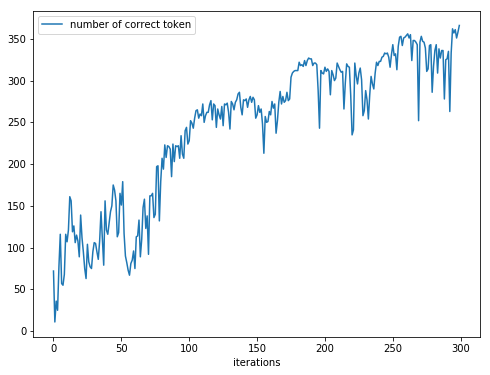

Number of correct predicted token


In [38]:

plt.figure(figsize=(8,6))
plt.plot(noCorrect,label="number of correct token")
plt.xlabel("iterations")
plt.legend()
plt.show()

print("Number of correct predicted token")

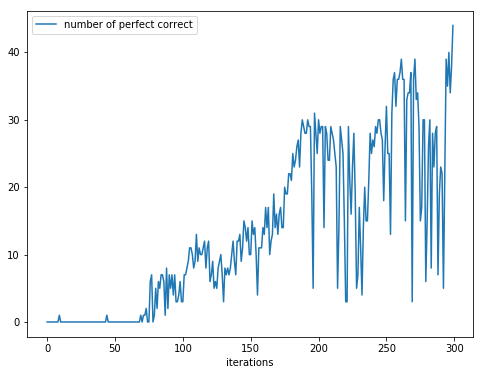

Number of correct predicted caption


In [39]:

plt.figure(figsize=(8,6))
plt.plot(noPerfectCorrect,label="number of perfect correct")
plt.xlabel("iterations")
plt.legend()
plt.show()

print("Number of correct predicted caption")

In [50]:
generator.eval()
with torch.no_grad():
    image,cap = next(iter(dataloader))
    ei,embed = prepareBatch(image,cap,model,7,5)
    predictedEmbed=generator(ei)
    
  
  


predictedEmbed = predictedEmbed.cpu().numpy().reshape(54,7,5)

predicted = []


for _ in predictedEmbed:
    temp = ""
    for i in _:
        temp= temp+" "+model.wv.most_similar(positive=[i],topn=1)[0][0]
    predicted.append(temp)
    
generator.train()


trueCap = padCap(cap)

In [99]:
predicted

[' a small hexagon in lower left <e>',
 ' a big pentagon in center <e> <e>',
 ' a big triangle <e> <e> <e> <e>',
 ' a big triangle at right <e> <e>',
 ' a small circle at top <e> <e>',
 ' a big triangle <e> <e> <e> <e>',
 ' a small hexagon in upper left <e>',
 ' a small hexagon in lower right <e>',
 ' a long straight line <e> <e> <e>',
 ' circle big star in upper right <e>',
 ' a big circle at top <e> <e>',
 ' a long curve line in center <e>',
 ' a big diamond at left <e> <e>',
 ' a long curve line in upper right',
 ' a big diamond in center <e> <e>',
 ' a small pentagon in upper left <e>',
 ' a small big in upper right <e>',
 ' a big rectangle in upper left <e>',
 ' a big rectangle at bottom <e> <e>',
 ' a short straight line at left <e>',
 ' a long curve line in center <e>',
 ' a small diamond in upper left <e>',
 ' a short straight line in center <e>',
 ' a big star in upper left <e>',
 ' a big rectangle in center <e> <e>',
 ' a small hexagon <e> <e> <e> <e>',
 ' a big triangle in u

In [100]:
#behtarin natije gerefte shode az in model ta konun
#362/378 token va 46/54 caption ast